In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import inspect
import os
import sys
import time

from copy import deepcopy

import bnpregcluster_runjingdev.regression_mixture_lib as gmm_lib

np.random.seed(42) # nothing special about this seed (we hope)!

In [2]:
reg_params = dict()
#datafile = 'fits/transformed_gene_regression_df7_degree3_genes10000.npz'
datafile = 'fits/transformed_gene_regression_df7_degree3_genes1000.npz'
with np.load(datafile) as infile:
    reg_params['beta_mean'] = infile['transformed_beta_mean']
    reg_params['beta_info'] = infile['transformed_beta_info']
    df = infile['df']
    degree = infile['degree']
    
num_genes = reg_params['beta_mean'].shape[0]
obs_dim = reg_params['beta_mean'].shape[1]

num_components = 100

analysis_name = 'transformed_gene_regression_df{}_degree{}_genes{}_num_components{}_fit'.format(
    df, degree, num_genes, num_components)
print(reg_params['beta_info'].shape, reg_params['beta_mean'].shape)

(700, 9, 9) (700, 9)


In [3]:
prior_params = gmm_lib.get_base_prior_params(obs_dim, num_components)
prior_params_pattern = gmm_lib.get_prior_params_pattern(obs_dim, num_components)
prior_params_pattern.validate_folded(prior_params)
gmm = gmm_lib.GMM(num_components, prior_params, reg_params)

In [4]:
print('Running k-means init.')
kmeans_params = \
    gmm_lib.kmeans_init(gmm.reg_params,
                        gmm.num_components, 50)
print('Done.')
init_gmm_params = dict()
init_gmm_params['centroids'] = kmeans_params['centroids']
init_gmm_params['stick_propn_mean'] = np.zeros(gmm.num_components - 1)
init_gmm_params['stick_propn_info'] = np.ones(gmm.num_components - 1)

init_x = gmm.gmm_params_pattern.flatten(init_gmm_params, free=True)

Running k-means init.
Done.


In [5]:
gmm.conditioned_obj.reset() # Reset the logging and iteration count.
gmm.conditioned_obj.set_print_every(1)

opt_time = time.time()
gmm_opt, init_x2 = gmm.optimize(init_x, gtol=1e-2)
opt_time = time.time() - opt_time

Iter 0: f = -108002.42924673
Iter 1: f = -108619.90673308
Iter 2: f = -109261.90400817
Iter 3: f = -109582.10318034
Iter 4: f = -107745.66651283
Iter 5: f = -109777.18630813
Iter 6: f = -109871.20230158
Iter 7: f = -109870.72536202
Iter 8: f = -109890.05221224
Iter 9: f = -109924.06407296
Iter 10: f = -109944.13948596
Iter 11: f = -109959.73286086
Iter 12: f = -109911.34713770
Iter 13: f = -109974.56777559
Iter 14: f = -109954.26474766
Iter 15: f = -109979.61076705
Iter 16: f = -109986.50098300
Iter 17: f = -109991.21214380
Iter 18: f = -109998.74540221
Iter 19: f = -110001.40703108
Iter 20: f = -110013.87989150
Iter 21: f = -110016.02503018
Iter 22: f = -110031.88527219
Iter 23: f = -110032.58826919
Iter 24: f = -110040.23020066
Iter 25: f = -110041.76020231
Iter 26: f = -110041.88922270
Iter 27: f = -110041.88975482
Iter 28: f = -110041.89001640
Iter 29: f = -110041.89136125
Iter 30: f = -110041.89136255


In [6]:
tic = time.time()
# Note that h_cond is the Hessian.
h_cond = gmm.update_preconditioner(init_x2)
opt_time += time.time() - tic

In [7]:
h_cond.shape, gmm.kl_obj.grad(init_x2).shape
#np.linalg.solve(h_cond, gmm.kl_obj.grad(init_x2))

((108, 108), (108,))

In [8]:
gmm.conditioned_obj.reset()
tic = time.time()
gmm_opt, gmm_opt_x = gmm.optimize_fully(
    init_x2, verbose=True, kl_hess=h_cond)
opt_time += time.time() - tic
print('Optimization time: {} seconds'.format(opt_time))

Iter 0: f = -110041.89136255
Preconditioned iteration 1
  Taking Newton step.
(108, 108)
(108,)
Iter 1: f = -110041.89136255
Iter 2: f = -110041.89136281
2.65252310782671e-07
Iter 3: f = -110041.89136281
Success.
  Running preconditioned optimization.
Iter 0: f = -110041.89136281
Iter 1: f = -110041.89136281
Iter 4: f = -110041.89136281
Preconditioned iteration 2
  Getting Hessian and preconditioner.
  Taking Newton step.
(108, 108)
(108,)
  Converging with small Newton step.
Optimization time: 25.120762825012207 seconds


In [9]:
opt_gmm_params = gmm.gmm_params_pattern.fold(gmm_opt_x, free=True)
print(opt_gmm_params.keys())
e_z = gmm.get_e_z(opt_gmm_params)
print(np.sort(np.mean(e_z, axis=0)))
print(np.sort(np.sum(e_z, axis=0)))

odict_keys(['centroids', 'stick_propn_mean', 'stick_propn_info'])
[0.02841139 0.03714784 0.05726712 0.08195504 0.08416892 0.09091715
 0.0946731  0.09521101 0.20712195 0.22312649]
[ 19.8879711   26.00348559  40.08698711  57.36852665  58.91824197
  63.64200288  66.27116963  66.647709   144.98536639 156.18853969]


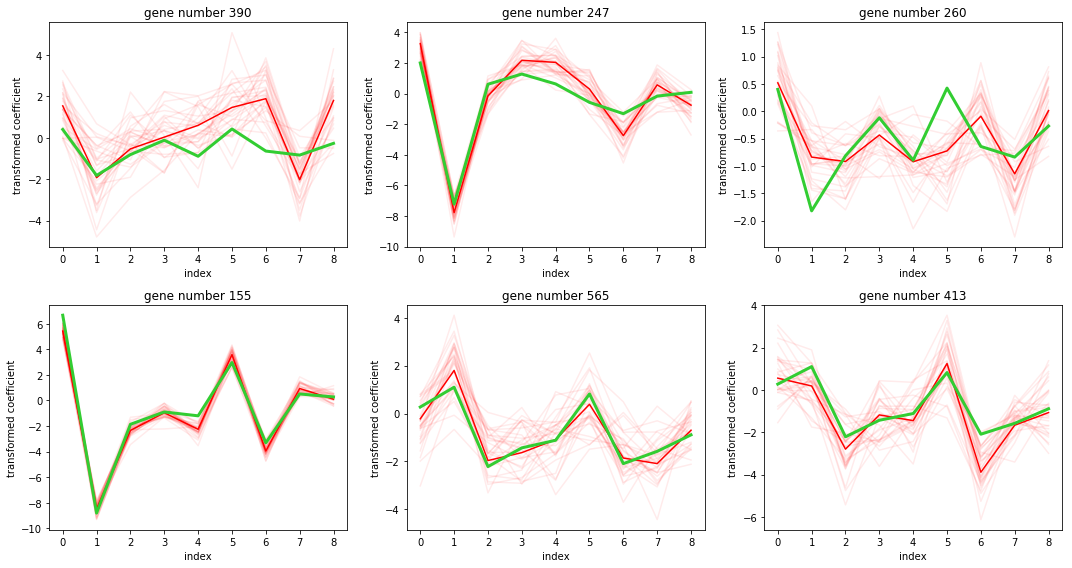

In [10]:
# Sanity check with a figure

f, axarr = plt.subplots(2, 3, figsize=(15,8))

plot_inds = np.random.choice(gmm.num_obs, 6, replace=False)
for i in range(6):
    n = plot_inds[i]
    this_plot = axarr[int(np.floor(i / 3)), i % 3] 
    this_plot.plot(gmm.reg_params['beta_mean'][n, :], color = 'red');
    this_plot.set_ylabel('transformed coefficient')
    this_plot.set_xlabel('index')
    this_plot.set_title('gene number {}'.format(n))

    # draw from the variational distribution to plot uncertainties
    for j in range(30): 
        transformed_beta_draw = np.random.multivariate_normal(
            gmm.reg_params['beta_mean'][n, :], \
             np.linalg.inv(gmm.reg_params['beta_info'][n, :, :]))

        axarr[int(np.floor(i / 3)), i % 3].plot(
            transformed_beta_draw, color = 'red', alpha = 0.08);

    k = np.argmax(e_z[n, :])
    this_plot.plot(opt_gmm_params['centroids'][k, :], color = 'limegreen', linewidth=3);

f.tight_layout()

In [11]:
save_dict = deepcopy(gmm_opt)
save_dict['df'] = df
save_dict['degree'] = degree
save_dict['datafile'] = datafile
save_dict['num_components'] = num_components
save_dict['gmm_params_pattern_json'] = \
    gmm.gmm_params_pattern.to_json()
save_dict['opt_gmm_params_flat'] = \
    gmm.gmm_params_pattern.flatten(opt_gmm_params, free=False)
save_dict['prior_params_pattern_json'] = \
    prior_params_pattern.to_json()
save_dict['prior_params_flat'] = \
    prior_params_pattern.flatten(prior_params, free=False)

save_dict['opt_time'] = opt_time

outfile = './fits/{}.npz'.format(analysis_name)
print('Saving to {}'.format(outfile))

np.savez_compressed(file=outfile, **save_dict)

Saving to ./fits/transformed_gene_regression_df7_degree3_genes700_num_components10_fit.npz
